In [1]:
from pystac_client import Client
import planetary_computer as pc

import os
import rasterio
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import shape

### Access NAIP image collection in Planetary Computer

In [2]:
# NCEAS bounding box (SB downtown)
reduce_box = {
    "type": "Polygon",
    "coordinates":[[[-119.706701282,34.4111229027],
                    [-119.6914677414,34.4111229027],
                    [-119.6914677414,34.4281372721],
                    [-119.706701282,34.4281372721],
                    [-119.706701282,34.4111229027]]],
}

# Temporal range of interest
date_range = "2018-01-01/2020-01-01"

In [3]:
# look in NAIP catalog for items on specified date and geographic range

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["naip"],
    intersects=reduce_box,
    datetime=date_range
)

items = list(search.get_items())
print(f"{len(items)} Items found in the 'new' range")

1 Items found in the 'new' range


In [4]:
# choose the item that has the most overlap:
area_shape = shape(reduce_box)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(reduce_box)).area
    return overlap_area / target_area

item = sorted(items, key=area_of_overlap, reverse=True)[0]
print(type(item))
print(item)
item.properties

<class 'pystac.item.Item'>
<Item id=ca_m_3411935_sw_11_060_20180724_20190209>


{'gsd': 0.6,
 'datetime': '2018-07-24T00:00:00Z',
 'naip:year': '2018',
 'proj:bbox': [246978.0, 3806856.0, 253212.0, 3814248.0],
 'proj:epsg': 26911,
 'naip:state': 'ca',
 'proj:shape': [12320, 10390],
 'proj:transform': [0.6, 0.0, 246978.0, 0.0, -0.6, 3814248.0, 0.0, 0.0, 1.0]}

In [5]:
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)

# Explore opened dataset
print(type(ds))
print('name: ')
print(ds.name)
print('mode: ', ds.mode)
print('# bands: ', ds.count)
print('height: ',ds.height)
print('width: ', ds.width)

print('spatial bounding box: ')
print(ds.bounds)
print('affine transform: ')
print(ds.transform)
print('CRS: ', ds.crs)

<class 'rasterio.io.DatasetReader'>
name: 
https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411935_sw_11_060_20180724_20190209.tif?st=2022-04-10T22%3A06%3A27Z&se=2022-04-18T22%3A06%3A27Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-04-11T22%3A06%3A26Z&ske=2022-04-18T22%3A06%3A26Z&sks=b&skv=2020-06-12&sig=/xB6KhWdkWRc4n7G3JIqGWxqwMjCoL9YZSf0%2B/wfH7k%3D
mode:  r
# bands:  4
height:  12320
width:  10390
spatial bounding box: 
BoundingBox(left=246978.0, bottom=3806856.0, right=253212.0, top=3814248.0)
affine transform: 
| 0.60, 0.00, 246978.00|
| 0.00,-0.60, 3814248.00|
| 0.00, 0.00, 1.00|
CRS:  EPSG:26911


## Select and save NIR band as .tif
Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1.

In [6]:
nir = ds.read(4)
#plt.imshow(nir)

# ----- Save NIR Raster as a .tif file -----
nirfp = os.path.join(os.getcwd(),'data','nir_scene.tif')
with rasterio.open(
    nirfp,
    'w',
    driver='GTiff',
    height=nir.shape[0],
    width=nir.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=nir.dtype,
    crs=ds.crs,
    transform=ds.transform,
) as dst:
    dst.write(nir, 1)

In [7]:
rgb = ds.read(indexes=[1, 2, 3])
#plt.imshow(rgb)

# ----- Save RGB Raster -----
rgbfp = os.path.join(os.getcwd(),'data','rgb_scene.tif')
with rasterio.open(
    rgbfp,
    'w',
    driver='GTiff',
    height=rgb.shape[1],
    width=rgb.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype=rgb.dtype,
    crs=ds.crs,
    transform=ds.transform,
) as dst:
    dst.write(rgb, [1,2,3])

In [8]:
## Reopen NIR and RGB with rioxarray

nir = rioxr.open_rasterio(nirfp)
#nir

print('original shape: ', nir.shape)
nir = nir.squeeze()
print('squeezed shape: ', nir.shape)
#nir.plot(figsize=(8,8))

original shape:  (1, 12320, 10390)
squeezed shape:  (12320, 10390)


In [9]:
rgb = rioxr.open_rasterio(rgbfp)
#rgb.plot.imshow(figsize=(8,8))

## POLYGON FOR CUTTING COMPLETE NAIP IMAGE
Obtained the bounding box coordinates from  https://boundingbox.klokantech.com

Select GeoJSON option at the bottom. These are in "EPSG:4326" CRS, so we will have to set that manually. 
https://datatracker.ietf.org/doc/html/rfc7946#ref-WGS84

In [10]:
reduce_shape = shape(reduce_box)

reduce = gpd.GeoDataFrame()
reduce.loc[0,'geometry']  = reduce_shape
reduce = reduce.set_crs("EPSG:4326")
# MATCH CRES WITH RASTERS
reduce = reduce.to_crs(rgb.rio.crs)
#reduce.crs

In [11]:
# ---- SAVE SHAPE ----
save = True
if(save):
    outfp = os.path.join(os.getcwd(),'data','reduce_box.shp')
    reduce.to_file(outfp)
    reduce = gpd.read_file(outfp)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## CLIP RGB NAIP IMAGE TO SMALLER REGION

In [12]:
rgb_small = rgb.rio.clip_box(*reduce.total_bounds)
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape, '\n')
print('original dtype :', rgb.dtype)
print('reduced dtype :', rgb_small.dtype)
#rgb_small.plot.imshow(figsize=(8,8))

original shape:  (3, 12320, 10390)
reduced shape:  (3, 3208, 2419) 

original dtype : uint8
reduced dtype : uint8


In [13]:
rgb_small_fp = os.path.join(os.getcwd(),'data','rgb.tif')

with rasterio.open(
    rgb_small_fp,
    'w',
    driver='GTiff',
    height=rgb_small.shape[1],
    width=rgb_small.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype=rgb_small.dtype,
    crs=rgb_small.rio.crs,
    transform=rgb_small.rio.transform(),
) as dst:
    dst.write(rgb_small.values, [1,2,3])

rgb_check = rioxr.open_rasterio(rgb_small_fp)
print('original shape:', rgb_small.shape)
print('saved shape:', rgb_check.shape)
print('saved dtype:',rgb_check.dtype)

#rgb_check.plot.imshow()

original shape: (3, 3208, 2419)
saved shape: (3, 3208, 2419)
saved dtype: uint8


In [14]:
# os.stat(<file_path>).st_size returns the file size in bytes
# divide by 1048576 to obtain size in megabytes
# GitHub only allows files of up to 25MB uploaded through the browser
os.stat(rgb_small_fp).st_size/1048576

22.22068214416504

## CLIP NAIP RASTERS TO SMALLER REGIONS

What's up with the star * at the front of `reduce.total_bounds
https://stackoverflow.com/questions/400739/what-does-asterisk-mean-in-python

Documentation for `rio.clip_box`
https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors

In [15]:
nir_small = nir.rio.clip_box(*reduce.total_bounds)
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)

original shape:  (12320, 10390)
reduced shape:  (3208, 2419)


In [16]:
#nir_small.plot(figsize=(8,8))

In [17]:
nir_reduced_fp = os.path.join(os.getcwd(),'data','nir.tif')

with rasterio.open(
    nir_reduced_fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height=nir_small.shape[0], 
    width=nir_small.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=nir_small.dtype,
    crs=nir_small.rio.crs,
    transform=nir_small.rio.transform(),
) as dst:
    dst.write(nir_small.values, 1)
    

nir_check = rioxr.open_rasterio(nir_reduced_fp)
print('original shape:', nir_small.shape)
print('saved shape:', nir_check.shape)
print('saved dtype:',nir_check.dtype)
#nir_check.plot()

original shape: (3208, 2419)
saved shape: (1, 3208, 2419)
saved dtype: uint8


In [18]:
os.stat(nir_reduced_fp).st_size/1048576

7.407121658325195

## NCEAS AOI box

In [19]:
aoi_box = {
    "type": "Polygon",
    "coordinates":[[[-119.7062718629,34.4222115638],
                    [-119.6951987997,34.4222115638],
                    [-119.6951987997,34.4276811896],
                    [-119.7062718629,34.4276811896],
                    [-119.7062718629,34.4222115638]]],
}

aoi_shape = shape(aoi_box)

aoi = gpd.GeoDataFrame()
aoi.loc[0,'geometry']  = aoi_shape
aoi = aoi.set_crs("EPSG:4326")


<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

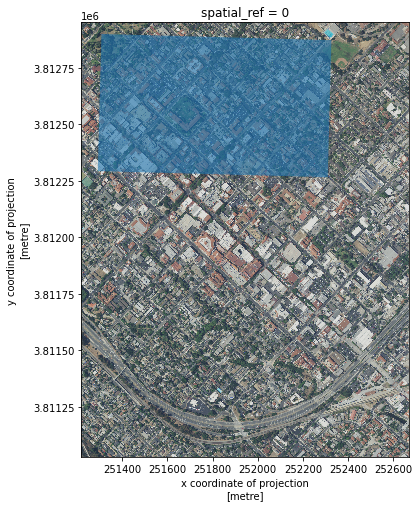

In [20]:
#bounds = box(*aoi.total_bounds)
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
rgb_small.plot.imshow(ax=ax)
aoi.to_crs(rgb.rio.crs).plot(ax=ax, alpha=0.6)

## SAVE AOI SHAPEFILE WITH ORIGINAL CRS

In [21]:
# SAVE SHAPE
aoifp = os.path.join(os.getcwd(),'data','nceas_aoi.shp')
aoi.to_file(aoifp)
aoi_check = gpd.read_file(aoifp)
aoi_check

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,FID,geometry
0,0,"POLYGON ((-119.70627 34.42221, -119.70627 34.4..."


## Other resources

https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-python

**How to make a  binder**

https://www.youtube.com/watch?v=owSGVOov9pQ

https://github.com/rasbt/watermark